In [9]:
import pandas as pd

In [10]:
data = pd.read_csv(r"C:\Users\Maria Paula\OneDrive\Documents\GitHub\airemty\base_final_imputada_por_zona.csv")
df = pd.DataFrame(data)

In [11]:
df.dtypes

Zona      object
date      object
SO2      float64
RAINF    float64
WSR      float64
WDR      float64
dtype: object

In [12]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year #extraigo el año

In [14]:
df_noche = df[(df["date"].dt.hour >= 20) | (df["date"].dt.hour <= 6)]
df_agrupado = df_noche.groupby(["Zona", "year"])


In [22]:
'''for (zona, año), grupo in df_agrupado:
    print(f"Zona: {zona}, Año: {año}, Registros: {len(grupo)}")
    display(grupo.head(1))'''

'for (zona, año), grupo in df_agrupado:\n    print(f"Zona: {zona}, Año: {año}, Registros: {len(grupo)}")\n    display(grupo.head(1))'

In [23]:
df_estadisticas = (
    df_agrupado['SO2']
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

# Si quieres valores absolutos de la media (opcional)
df_estadisticas['mean'] = df_estadisticas['mean'].abs()
df_estadisticas['median'] = df_estadisticas['median'].abs()
df_estadisticas['std'] = df_estadisticas['std'].abs()
df_estadisticas['min'] = df_estadisticas['min'].abs()

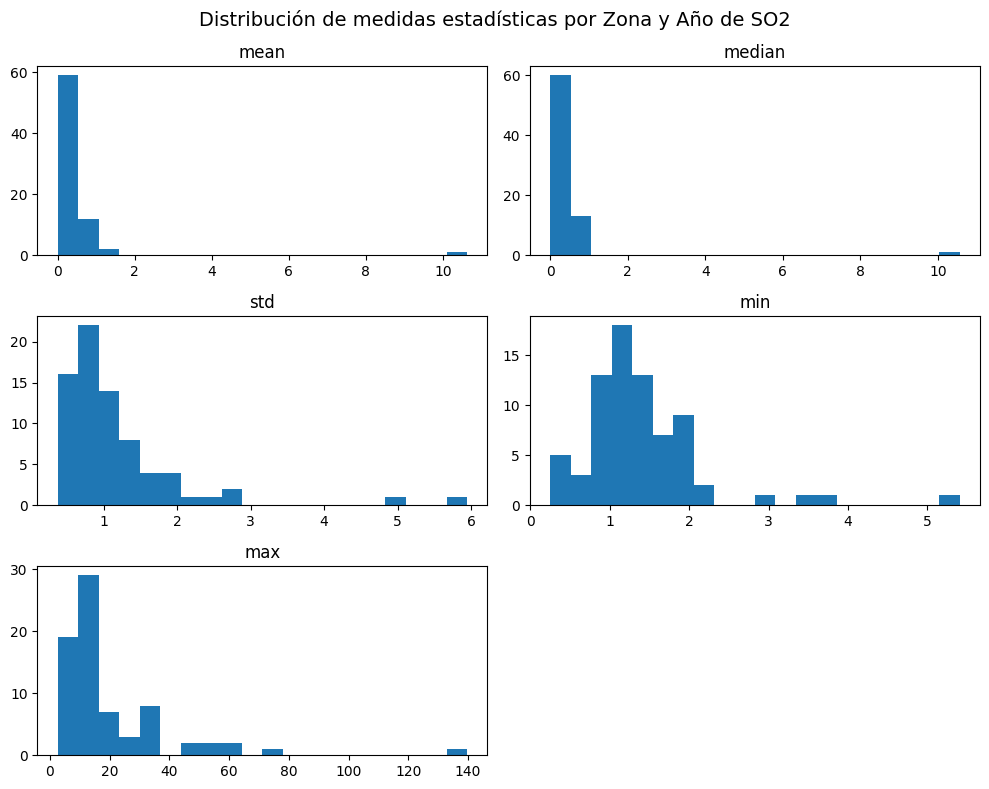

In [24]:
import matplotlib.pyplot as plt

df_estadisticas[['mean', 'median', 'std', 'min', 'max']].hist(
    bins=20,
    figsize=(10, 8),
    grid=False
)

plt.suptitle("Distribución de medidas estadísticas por Zona y Año de SO2", fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
df_estadisticas

,Zona,year,mean,median,std,min,max
0,Centro,2021,0.095223,0.047403,0.892225,1.140242,6.802133
1,Centro,2022,0.482495,0.432506,0.952164,0.943649,27.483763
2,Centro,2023,0.325161,0.432506,0.484587,1.376154,5.583254
3,Centro,2024,0.049840,0.157275,0.871856,0.863917,31.238697
4,Centro,2025,0.329835,0.275231,1.438193,0.904330,32.162686
...,...,...,...,...,...,...,...
69,Suroeste2,2021,0.054631,0.176471,0.810503,1.882353,14.823529
70,Suroeste2,2022,0.597563,0.352941,1.555068,0.941176,47.117647
71,Suroeste2,2023,0.041053,0.235294,0.925480,1.882353,14.764706
72,Suroeste2,2024,0.155975,0.294118,1.104640,1.470588,16.352941


In [26]:
from tslearn.metrics import cdist_dtw
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

FEATURES = ['mean', 'median', 'std', 'min', 'max']

dfs_por_anio = {}
for y in sorted(df_estadisticas['year'].unique()):
    sub = (
        df_estadisticas.loc[df_estadisticas['year'] == y, ['Zona', 'year'] + FEATURES]
        .drop_duplicates(subset=['Zona'])        # por si hay repetidas
        .set_index('Zona')                       # etiquetas del dendrograma
    )
    # Quédate con columnas numéricas (por si se coló algo)
    sub_num = sub.select_dtypes(include='number')
    dfs_por_anio[y] = sub_num
    
df_2022 = dfs_por_anio[2022].select_dtypes(include='number')
df_2021 = dfs_por_anio[2021].select_dtypes(include='number')
df_2023 = dfs_por_anio[2023].select_dtypes(include='number')
df_2024 = dfs_por_anio[2024].select_dtypes(include='number')
df_2025 = dfs_por_anio[2025].select_dtypes(include='number')


In [27]:
df_2023

,year,mean,median,std,min,max
Zona,,,,,,
Centro,2023,0.325161,0.432506,0.484587,1.376154,5.583254
Noreste,2023,0.353642,0.500000,1.256158,1.150000,53.850000
Noreste2,2023,0.084894,0.303030,0.743638,1.030303,10.515152
Noreste3,2023,0.370337,0.589915,1.128586,3.044744,12.978132
Noroeste,2023,0.290293,0.444444,0.692355,1.074074,10.666667
Noroeste2,2023,0.457437,0.532175,0.464126,1.689588,8.204369
Noroeste3,2023,0.167992,0.222222,1.904472,1.833333,34.944444
Norte,2023,0.468734,0.562500,1.042187,2.000000,30.062500
Norte2,2023,0.157275,0.345912,0.831815,0.986299,16.441364


C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_27868\2988168108.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='ward', metric='euclidean')


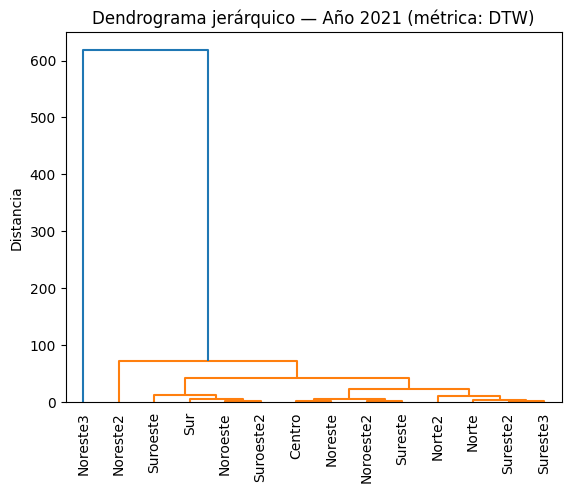

In [28]:
# Matriz de distancias DTW
dist_matrix = cdist_dtw(df_2021)

# Clustering jerárquico
Z = linkage(dist_matrix, method='ward', metric='euclidean')

dendrogram(Z, labels=df_2021.index.tolist(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma jerárquico — Año 2021 (métrica: DTW)")
plt.ylabel("Distancia")
plt.show()

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_27868\1029131563.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_2 = linkage(dist_matrix_2, method='ward', metric='euclidean')


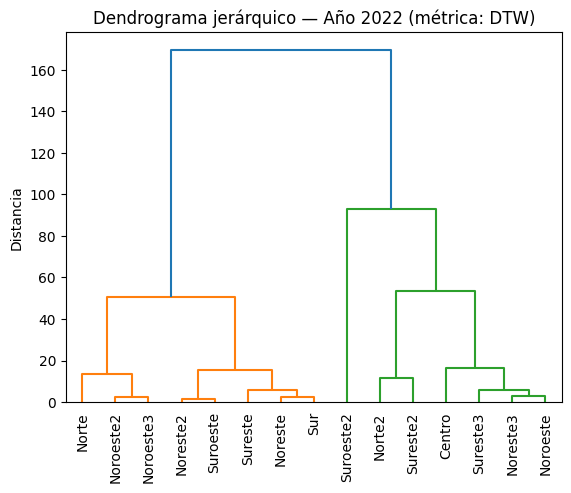

In [29]:
# Matriz de distancias DTW
dist_matrix_2 = cdist_dtw(df_2022)

# Clustering jerárquico
Z_2 = linkage(dist_matrix_2, method='ward', metric='euclidean')

dendrogram(Z_2, labels=df_2022.index.tolist(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma jerárquico — Año 2022 (métrica: DTW)")
plt.ylabel("Distancia")
plt.show()

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_27868\2621712868.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_3 = linkage(dist_matrix_3, method='ward', metric='euclidean')


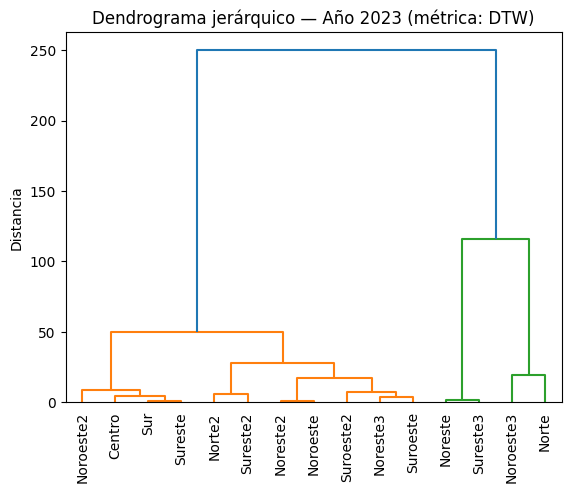

In [30]:
# Matriz de distancias DTW
dist_matrix_3 = cdist_dtw(df_2023)

# Clustering jerárquico
Z_3 = linkage(dist_matrix_3, method='ward', metric='euclidean')

dendrogram(Z_3, labels=df_2023.index.tolist(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma jerárquico — Año 2023 (métrica: DTW)")
plt.ylabel("Distancia")
plt.show()

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_27868\96016987.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_4 = linkage(dist_matrix_4, method='ward', metric='euclidean')


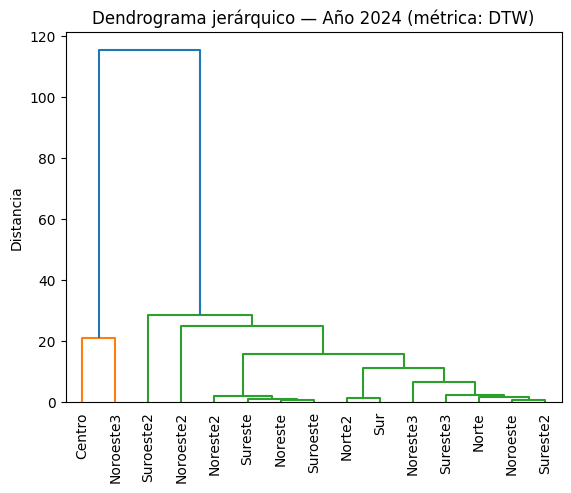

In [31]:
# Matriz de distancias DTW
dist_matrix_4 = cdist_dtw(df_2024)

# Clustering jerárquico
Z_4 = linkage(dist_matrix_4, method='ward', metric='euclidean')

dendrogram(Z_4, labels=df_2024.index.tolist(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma jerárquico — Año 2024 (métrica: DTW)")
plt.ylabel("Distancia")
plt.show()

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_27868\1163026168.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_5 = linkage(dist_matrix_5, method='ward', metric='euclidean')


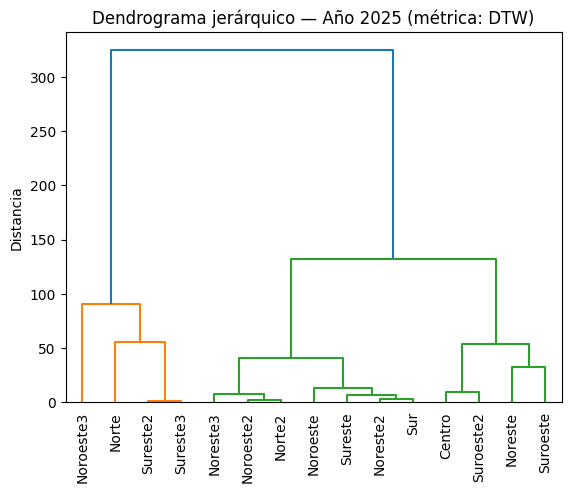

In [32]:
# Matriz de distancias DTW
dist_matrix_5 = cdist_dtw(df_2025)

# Clustering jerárquico
Z_5 = linkage(dist_matrix_5, method='ward', metric='euclidean')

dendrogram(Z_5, labels=df_2025.index.tolist(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma jerárquico — Año 2025 (métrica: DTW)")
plt.ylabel("Distancia")
plt.show()

# K óptimo

Mejor k común (media Silhouette alta y estable): 2
k= 2  Silhouette mean=0.740  std=0.101
k= 3  Silhouette mean=0.627  std=0.084
k= 4  Silhouette mean=0.540  std=0.060
k= 5  Silhouette mean=0.528  std=0.083
k= 6  Silhouette mean=0.473  std=0.092
k= 7  Silhouette mean=0.483  std=0.050
k= 8  Silhouette mean=0.452  std=0.061
k= 9  Silhouette mean=0.362  std=0.074
k=10  Silhouette mean=0.285  std=0.082


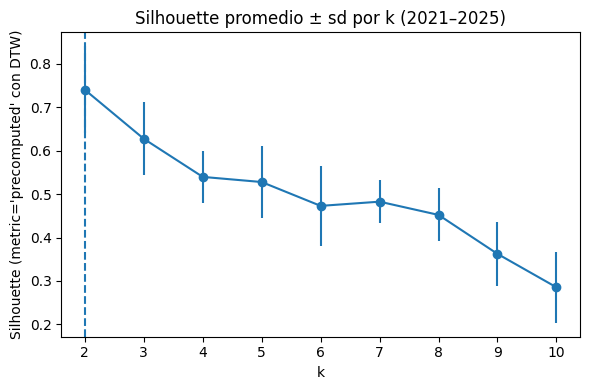

In [33]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

years = [2021, 2022, 2023, 2024, 2025]
dist_mats = {
    2021: dist_matrix,
    2022: dist_matrix_2,
    2023: dist_matrix_3,
    2024: dist_matrix_4,
    2025: dist_matrix_5,
}
links = {2021: Z, 2022: Z_2, 2023: Z_3, 2024: Z_4, 2025: Z_5}

# Rango de k a evaluar
k_min, k_max = 2, 10
ks = range(k_min, k_max + 1)

sil_means, sil_stds = [], []

labels_by_year_k = {y: {} for y in years}

for k in ks:
    sil_year = []
    for y in years:
        Z = links[y]
        D = dist_mats[y]
        # Cortar el dendrograma
        labels = fcluster(Z, k, criterion='maxclust')
        labels_by_year_k[y][k] = labels
        # Silhouette con distancias precomputadas
        s = silhouette_score(D, labels, metric='precomputed')
        sil_year.append(s)
    sil_means.append(np.mean(sil_year))
    sil_stds.append(np.std(sil_year, ddof=1))

# Selección de k*: mayor media y, si empata, menor desviación
sil_means = np.array(sil_means)
sil_stds = np.array(sil_stds)

best_idx = np.lexsort((sil_stds * 1.0, -sil_means))  # ordena por (-mean, std)
k_star = list(ks)[best_idx[0]]

print(f"Mejor k común (media Silhouette alta y estable): {k_star}")
for k, m, s in zip(ks, sil_means, sil_stds):
    print(f"k={k:2d}  Silhouette mean={m:.3f}  std={s:.3f}")

# (Opcional) Grafiquito para ver el trade-off
plt.figure(figsize=(6,4))
plt.errorbar(list(ks), sil_means, yerr=sil_stds, fmt='-o')
plt.axvline(k_star, linestyle='--')
plt.title("Silhouette promedio ± sd por k (2021–2025)")
plt.xlabel("k")
plt.ylabel("Silhouette (metric='precomputed' con DTW)")
plt.tight_layout()
plt.show()

# Clusters por año

In [34]:
from scipy.cluster.hierarchy import fcluster

labels = fcluster(Z, 2, criterion='maxclust')  # fuerza 2 clústeres
labels_2 = fcluster(Z_2, 2, criterion='maxclust')  
labels_3 = fcluster(Z_3, 2, criterion='maxclust')  
labels_4 = fcluster(Z_4, 2, criterion='maxclust')  
labels_5 = fcluster(Z_5, 2, criterion='maxclust')

import pandas as pd
Clust_anio = pd.DataFrame({
    'objeto': df_2025.index,
    'cluster_2021': labels,
    'cluster_2022': labels_2,
    'cluster_2023': labels_3,
    'cluster_2024': labels_4,
    'cluster_2025': labels_5,
}).set_index('objeto')
Clust_anio

,cluster_2021,cluster_2022,cluster_2023,cluster_2024,cluster_2025
objeto,,,,,
Centro,2,2,1,1,2
Noreste,2,1,2,2,2
Noreste2,2,1,1,2,2
Noreste3,2,2,1,2,2
Noroeste,2,2,1,2,2
Noroeste2,2,1,1,2,2
Noroeste3,1,1,2,1,1
Norte,1,1,2,2,1
Norte2,2,2,1,2,2


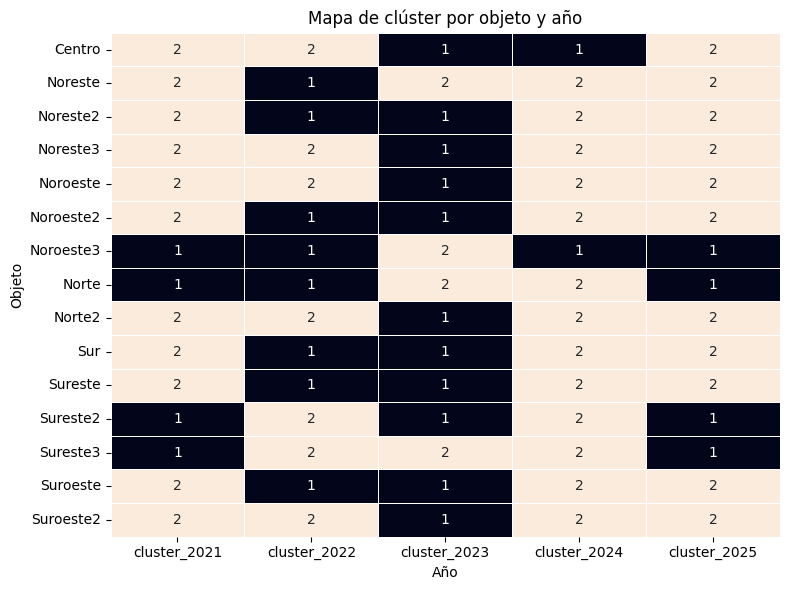

In [35]:
import matplotlib.pyplot as plt

# --- Asumo tu tabla tal cual la mostraste:
# Clust_anio: index = objeto, columnas = cluster_2021 ... cluster_2025 con valores 1/2
Clust_graf = Clust_anio.copy()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(Clust_graf[["cluster_2021",	"cluster_2022",	"cluster_2023",	"cluster_2024",	"cluster_2025"]], annot=True, fmt=".0f", cbar=False, linewidths=.5)
plt.title("Mapa de clúster por objeto y año")
plt.xlabel("Año")
plt.ylabel("Objeto")
plt.tight_layout()
plt.show()


# Gráficas en mapa de las estaciones y la refineria

In [36]:
import folium
from folium import Circle, Marker

In [37]:
data_ref = pd.read_csv(r'C:\Users\Maria Paula\OneDrive\Documents\GitHub\airemty\distancias_a_refineria.csv')
df_ref = pd.DataFrame(data_ref)
df_ref.head()

,station,lat,lon,elev_m,distance_km,delta_elev_m
0,SE3,25.601111,-99.999167,334,5.6673,-26
1,SE2,25.645833,-100.095278,387,16.4081,27
2,NE3,25.790556,-100.078333,346,26.1374,-14
3,SE,25.665278,-100.243611,500,31.1865,140
4,NE2,25.777222,-100.188056,432,32.1738,72


In [38]:
import folium
from folium import Circle, Marker

# Coordenadas de la Refinería de Cadereyta
ref_lat, ref_lon = 25.59056, -100.00139

# Crear mapa centrado en la refinería
mapa = folium.Map(location=[ref_lat, ref_lon], zoom_start=9, tiles="OpenStreetMap")

# Agregar marcador de la refinería
Marker(
    location=[ref_lat, ref_lon],
    popup="Refinería de Cadereyta",
    icon=folium.Icon(color="red", icon="industry", prefix="fa")
).add_to(mapa)

# Agregar círculo de referencia (50 km)
Circle(
    location=[ref_lat, ref_lon],
    radius=50000,  # 50 km
    color="blue",
    fill=True,
    fill_opacity=0.05,
    popup="Radio 50 km de la Refinería"
).add_to(mapa)

# Recorrer filas del DataFrame df_ref
for idx, row in df_ref.iterrows():
    elev = row['elev_m']
    delta = row['delta_elev_m']
    
    # Definir color según delta de elevación
    if delta < 0:
        color = "blue"
    elif delta < 150:
        color = "green"
    elif delta < 250:
        color = "orange"
    else:
        color = "red"
    
    # Agregar marcador de estación
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(
            f"<b>{row['station']}</b><br>"
            f"Elevación: {elev} m<br>"
            f"ΔElev: {delta:+} m<br>"
            f"Distancia: {row['distance_km']:.1f} km",
            max_width=250
        )
    ).add_to(mapa)

# Mostrar el mapa
mapa


# Animación Clusters por año

In [39]:
import folium
from folium import Circle, Marker
from folium.plugins import TimestampedGeoJson
import pandas as pd
from datetime import datetime

# ---------------------------
# INPUTS
# ---------------------------
# Years present in your cluster columns
years = [2021, 2022, 2023, 2024, 2025]

# Map cluster → color (change if you add more clusters)
cluster_color = {1: "#b41f1f",  # 
                 2: "#fffb0e"}  # 

# ---------------------------
# BASE MAP (your original bits)
# ---------------------------
ref_lat, ref_lon = 25.59056, -100.00139
m = folium.Map(location=[ref_lat, ref_lon], zoom_start=9, tiles="OpenStreetMap")

Marker(
    location=[ref_lat, ref_lon],
    popup="Refinería de Cadereyta",
    icon=folium.Icon(color="red", icon="industry", prefix="fa")
).add_to(m)

Circle(
    location=[ref_lat, ref_lon],
    radius=50000,  # 50 km
    color="blue",
    fill=True,
    fill_opacity=0.05,
    popup="Radio 50 km de la Refinería"
).add_to(m)

# ---------------------------
# BUILD A TIME-ENABLED GEOJSON
# ---------------------------
# Helper to pick color from your delta elev logic (optional; used in popup info)
def elev_color(delta):
    if delta < 0:
        return "blue"
    elif delta < 150:
        return "green"
    elif delta < 250:
        return "orange"
    return "red"

features = []
# --- 1) Diccionario: station (df_ref) -> objeto (Clust_anio) ---
# AJÚSTALO a tus nombres reales:
station_to_obj = {
    "CE": "Centro",
    "NTE": "Norte",      "NTE2": "Norte2",
    "NE": "Noreste",   "NE2": "Noreste2",   "NE3": "Noreste3",
    "NO": "Noroeste",  "NO2": "Noroeste2",  "NO3": "Noroeste3",
    "SUR": "Sur",
    "SE": "Sureste",   "SE2": "Sureste2",   "SE3": "Sureste3",
    "SO": "Suroeste",  "SO2": "Suroeste2",  "SO3": "Suroeste3",
    
}

# --- 2) Prepara Clust_anio para unir ---
# Si Clust_anio tiene 'objeto' como índice, pásalo a columna
if "objeto" not in Clust_anio.columns:
    Clust_anio = Clust_anio.reset_index()  # ahora tiene columna 'objeto'
    if "objeto" not in Clust_anio.columns and "index" in Clust_anio.columns:
        Clust_anio = Clust_anio.rename(columns={"index": "objeto"})

cluster_cols = ["cluster_2021","cluster_2022","cluster_2023","cluster_2024","cluster_2025"]

df_ref["objeto"] = df_ref["station"].map(station_to_obj)

# (opcional) ver qué estaciones no se mapearon y arreglar el diccionario si sale algo
faltan = df_ref[df_ref["objeto"].isna()]["station"].unique().tolist()
if faltan: print("⚠️ Estaciones sin mapeo:", faltan)

# 2) Ahora sí: merge por 'objeto'
cluster_cols = ["cluster_2021","cluster_2022","cluster_2023","cluster_2024","cluster_2025"]
df_all = df_ref.merge(Clust_anio[["objeto"] + cluster_cols], on="objeto", how="left")

for y in years:
    # a fake timestamp per year (TimestampedGeoJson needs a time)
    ts = datetime(y, 1, 1).strftime("%Y-%m-%dT%H:%M:%S")

    # the cluster column name, e.g., cluster_2021
    ccol = f"cluster_{y}"
    for _, r in df_all.iterrows():
        cl = int(r[ccol])
        color = cluster_color.get(cl, "#999999")

        # Build one Feature per station per year
        feat = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [float(r["lon"]), float(r["lat"])]
            },
            "properties": {
                "time": ts,
                "icon": "circle",
                "iconstyle": {
                    "fillColor": color,
                    "fillOpacity": 0.9,
                    "stroke": True,
                    "color": color,
                    "weight": 1,
                    "radius": 7
                },
                "popup": (
                    f"<b>{r['station']}</b><br>"
                    f"Año: {y}<br>"
                    f"Cluster: {cl}<br>"
                    f"Elevación: {r['elev_m']} m<br>"
                    f"ΔElev: {r['delta_elev_m']:+} m "
                    f"({elev_color(r['delta_elev_m'])})<br>"
                    f"Distancia: {r['distance_km']:.1f} km"
                ),
                # style for non-point (not used here),
                # but TimestampedGeoJson expects style keys
                "style": {"color": color, "weight": 1}
            }
        }
        features.append(feat)

geojson = {
    "type": "FeatureCollection",
    "features": features
}

TimestampedGeoJson(
    data=geojson,
    transition_time=400,    # ms between frames
    period="P1Y",           # 1-year steps
    add_last_point=False,
    auto_play=False,
    loop=False,
    max_speed=1,            # slider max
    loop_button=True,
    date_options="YYYY",    # show just the year on the control
    time_slider_drag_update=True
).add_to(m)

# Optional legend
legend_html = """
<div style='position: fixed; bottom: 30px; left: 30px; z-index:9999; 
     background: white; padding: 10px 12px; border: 1px solid #ccc; 
     border-radius: 6px; font-size: 14px;'>
<b>Clusters</b><br>
<span style='display:inline-block;width:12px;height:12px;background:#b41f1f;margin-right:6px;'></span> 1<br>
<span style='display:inline-block;width:12px;height:12px;background:#fffb0e;margin-right:6px;'></span> 2
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m  # display in Jupyter / save as HTML with m.save("clusters_anim.html")


# Medidas descriptivas por Cluster

In [40]:
for y in [2021, 2022, 2023, 2024, 2025]:
    ccol = f"cluster_{y}"
    df_year = globals()[f"df_{y}"]  # accede a df_2021, df_2022, etc.
    df_year = df_year.merge(Clust_anio[["objeto", ccol]], left_on="Zona", right_on="objeto", how="left")
    globals()[f"df_{y}"] = df_year  # actualiza el dataframe en memoria


In [41]:
# Diccionario para guardar los resultados de cada año
resumenes = {}

# Bucle para calcular automáticamente el resumen de cada año
for year in [2021, 2022, 2023, 2024, 2025]:
    df = globals().get(f"df_{year}")  # obtiene la variable df_2021, df_2022, etc.
    
    if df is not None:  # verifica que exista
        resumen = (
            df.groupby(f'cluster_{year}')
              .agg({
                  'mean': ['mean', 'std'],
                  'median': ['mean'],
                  'std': ['mean'],
                  'min': ['mean'],
                  'max': ['mean']
              })
        )
        # Aplana las columnas para que sean más legibles
        resumen.columns = ['_'.join(col) for col in resumen.columns]
        resumen.reset_index(inplace=True)
        
        # Guarda el resultado
        resumenes[year] = resumen

In [42]:
res_2021 = resumenes[2021]
res_2022 = resumenes[2022]
res_2023 = resumenes[2023]
res_2024 = resumenes[2024]
res_2025 = resumenes[2025]

In [43]:
resumen_todos = pd.concat(
    [res_2021.assign(year=2021),
     res_2022.assign(year=2022),
     res_2023.assign(year=2023),
     res_2024.assign(year=2024),
     res_2025.assign(year=2025)],
    ignore_index=True
)

# Mostrar el resultado medias de medidas estadisticas de concentracion de SO2
resumen_todos[[	'year','mean_mean',	'mean_std',	'median_mean',	'std_mean',	'min_mean',	'max_mean']]

,year,mean_mean,mean_std,median_mean,std_mean,min_mean,max_mean
0,2021,0.161249,0.080545,0.288014,1.199328,1.656511,11.135065
1,2021,0.419390,0.364971,0.229510,1.613362,1.927595,24.949833
2,2022,0.294486,0.289873,0.281328,0.764175,1.249101,8.587906
3,2022,0.370156,0.290000,0.255270,1.300003,1.313523,29.960075
4,2023,0.272064,0.162460,0.415890,0.687689,1.442069,11.226788
5,2023,0.255908,0.193345,0.370316,1.375962,1.616856,43.247558
6,2024,0.044991,0.006857,0.161971,1.030115,0.959736,28.536015
7,2024,0.158766,0.142152,0.243950,0.681417,1.318183,9.811564
8,2025,0.819597,0.301051,0.308013,2.528182,0.649845,60.761771
9,2025,1.326248,3.095955,1.228614,1.429880,1.249935,16.777937


# Promedio de distancia de estaciones por cluster a refineria

In [44]:
import pandas as pd

# Lista de columnas de cluster por año
cluster_cols = ["cluster_2021", "cluster_2022", "cluster_2023", "cluster_2024", "cluster_2025"]

# Diccionario donde se guardará el resultado
dist_med_porclust = {}

# Calcular la distancia promedio por cluster para cada año
for col in cluster_cols:
    # Agrupamos por el cluster de ese año y calculamos la media de las distancias
    dist_med = df_all.groupby(col)['distance_km'].mean()
    
    # Guardamos el resultado
    dist_med_porclust[col] = dist_med

# Convertimos el resultado a un DataFrame para ver todo junto
dist_med_porclust_df = pd.DataFrame(dist_med_porclust)
dist_med_porclust_df


,cluster_2021,cluster_2022,cluster_2023,cluster_2024,cluster_2025
1,30.677450,44.171063,39.529809,48.201750,30.677450
2,41.262255,31.889443,35.441675,36.937777,41.262255
